# Data Analysis - Visualizations

In [3]:
# Manipulation and Visualization
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import unidecode
import plotly.graph_objects as go
import plotly.express as px
import json

# API and Web Scraping
import requests
from datetime import datetime
from bs4 import BeautifulSoup

# Machine Learning - Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import normalize, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import RFECV

# Machine Learning - Modelling & Metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


## (1) Final Data Cleaning and Feature Engineering

In [5]:
f1_data = pd.read_csv(r'/Users/julianterenzio/Desktop/f1_final_df.csv')
f1_races = pd.read_csv(r'/Users/julianterenzio/Desktop/f1_races_df.csv')

# Convert dates into datetimes and find relative driver age

f1_races['race_date'] = pd.to_datetime(f1_races['race_date'])
f1_races['dateOfBirth'] = pd.to_datetime(f1_races['dateOfBirth'])
f1_races['driver_age'] = [relativedelta(x, y).years for x, y in zip(f1_races['race_date'], f1_races['dateOfBirth'])]

f1_data['race_date'] = pd.to_datetime(f1_data['race_date'])
f1_data['dateOfBirth'] = pd.to_datetime(f1_data['dateOfBirth'])
f1_data['driver_age'] = [relativedelta(x, y).years for x, y in zip(f1_data['race_date'], f1_data['dateOfBirth'])]


# Clean DNF status data to reflect concise categorical variables

def accident(x):
    if x in ['collision damage','accident','collision','disqualified','damage','spun off','retired']:
        return 'accident'
    else:
        return x

def categories(x):
    if x == 'finished' or x == 'lapped' or x == 'accident':
        return x
    else:
        return 'mechanical_issue'

f1_data['DNF_status'] = f1_data['DNF_status'].apply(lambda x: x.lower())
f1_data.loc[f1_data['DNF_status'].str.contains('lap'), 'DNF_status'] = 'lapped'
f1_data['DNF_status'] = f1_data['DNF_status'].apply(accident)
f1_data['DNF_status'] = f1_data['DNF_status'].apply(categories)

f1_data = f1_data.sort_values(['season', 'round', 'podium'], ascending=(True, True, True))


# Clean qualifying data from string object to seconds float

def clean_times(factor, df_series):
    f1_data[df_series].fillna('00:00.000', inplace = True)
    f1_data.replace({df_series: {'DEL': '00:00.000', 'DNF': '00:00.000', 'DNS': '00:00.000'}}, inplace = True) 
    f1_data[df_series+'_v2'] = [(sum([x * y for x, y in zip(factor, map(float, n.split(':')))]) if ':' in n else float(n)) for n in f1_data[df_series]]

clean_times([60, 1], 'Time')
clean_times([60, 1], 'Q1')
clean_times([60, 1], 'Q2')
clean_times([60, 1], 'Q3')


# Engineer qualifying time feature to reflect cumulative difference from fastest qualifier

f1_data['qualy_list'] = f1_data[['Time_v2', 'Q1_v2', 'Q2_v2', 'Q3_v2']].values.tolist()
f1_data['qualy_list'] = [[item for item in x if item != 0.0] for x in f1_data['qualy_list']]
f1_data = f1_data[f1_data['qualy_list'].map(lambda x: len(x)) > 0]
f1_data['qualy_time'] = [min(x) for x in f1_data['qualy_list']]
f1_data.drop(['Time', 'Q1', 'Q2', 'Q3', 'Time_v2', 'Q1_v2', 'Q2_v2', 'Q3_v2', 'qualy_list'], axis = 1, inplace = True)
f1_data.sort_values(['season', 'round', 'podium'], inplace = True)
f1_data['qualifying_time_diff'] = f1_data.groupby(['season', 'round']).qualy_time.diff()
f1_data['qualy_sec'] = f1_data.groupby(['season', 'round']).qualifying_time_diff.cumsum().fillna(0.000)
f1_data.drop(['qualifying_time_diff', 'qualy_time'], axis = 1, inplace = True)


# Engineer/clean finishing time data to reflect cumulative difference from fastest (first place) driver
## Null finish times for drivers that have been "lapped" or "dnf" reflect the slowest finish time + 10 second error factor

max_finish = f1_data.groupby(['season', 'round']).max().reset_index()[['season', 'round','finish_ms']]
max_finish.rename(columns = {'finish_ms': 'finish_ms_v2'}, inplace = True)
f1_data['finish_ms'] = f1_data['finish_ms'].fillna(0.0)
merged_df = pd.merge(f1_data, 
                     max_finish, 
                     how='inner', 
                     on=['season', 'round']).fillna(0.0)
merged_df['finish_ms_v2'] = merged_df['finish_ms_v2'] + (merged_df['podium']*1000.0)
f1_data['finish_ms'] = [merged_df.iloc[i,-1] if x == 0.0 else x for i, x in enumerate(f1_data['finish_ms'])]
f1_data['finish_sec_v1'] = f1_data['finish_ms'] / 1000.0
f1_data['finish_sec_diff'] = f1_data.groupby(['season', 'round']).finish_sec_v1.diff()
f1_data['finish_sec'] = f1_data.groupby(['season', 'round']).finish_sec_diff.cumsum().fillna(0.000)
f1_data.drop(['finish_sec_diff', 'finish_sec_v1'], axis = 1, inplace = True)


# Turn DNF_status into binary variable columns for better analysis and feature engineering

for status in f1_data['DNF_status'].unique():
    f1_data[status] = f1_data['DNF_status'].apply(lambda x: 1 if (status == x) else 0)

f1_data['cum_finish_ratio'] = f1_data.groupby(['full_name']).finished.cumsum() / (f1_data.groupby(['full_name']).finished.cumcount() + 1)
f1_data['cum_accident_ratio'] = f1_data.groupby(['full_name']).accident.cumsum() / (f1_data.groupby(['full_name']).finished.cumcount() + 1)
f1_data['cum_lapped_ratio'] = f1_data.groupby(['full_name']).lapped.cumsum() / (f1_data.groupby(['full_name']).finished.cumcount() + 1)
f1_data[['cum_finish_ratio', 'cum_accident_ratio', 'cum_lapped_ratio']] = f1_data[['cum_finish_ratio', 'cum_accident_ratio', 'cum_lapped_ratio']].round(5)

f1_data = f1_data.drop(['finished', 'lapped', 'mechanical_issue', 'accident'], axis=1)


# Clean "0" Qualifying Errors

f1_data = f1_data[(f1_data['grid_position'] != 0)].reset_index()


# Only as good as your last race: calcualte the 3-race rolling average finishing time

final_df = pd.DataFrame()
for name in f1_data['full_name'].unique():
    test_df = f1_data
    test_df = test_df[(test_df['full_name'] == name)].reset_index()
    test_df['rolling_3_finish_sec'] = test_df['finish_sec'].transform(lambda x: round(x.rolling(3, min_periods=0).mean().shift().bfill(), 3))
    test_df['rolling_3_qualy_sec'] = test_df['qualy_sec'].transform(lambda x: round(x.rolling(3, min_periods=0).mean().shift().bfill(), 3))
    final_df = pd.concat([final_df, test_df])

final_df['rolling_3_finish_sec'] = final_df['rolling_3_finish_sec'].fillna(0.000)
final_df['rolling_3_qualy_sec'] = final_df['rolling_3_qualy_sec'].fillna(0.000)
final_df = final_df.drop(['index'], axis=1)
final_df = final_df.sort_values(['season', 'round', 'podium'], ascending=(True, True, True)).reset_index(drop=True)


# Voila!

pd.set_option('display.max_columns', None)
print(f1_data.shape)
print(final_df.shape)
display(final_df.tail())


(14039, 36)
(14039, 38)


,level_0,season,round,circuit_id,country,lat,long,race_date,grid_position,podium,points_earned,finish_ms,DNF_status,constructor,full_name,dateOfBirth,nationality,points_after,wins_after,points_before,wins_before,c_points_after,c_wins_after,c_points_before,c_wins_before,warm_weather,cold_weather,dry_weather,wet_weather,cloudy_weather,driver_age,qualy_sec,finish_sec,cum_finish_ratio,cum_accident_ratio,cum_lapped_ratio,rolling_3_finish_sec,rolling_3_qualy_sec
14034,14034,2020,17,yas_marina,UAE,24.4672,54.6031,2020-12-13,14,16,0.0,5894363.0,lapped,alfa,antonio_giovinazzi,1993-12-14,Italian,4.0,0.0,4.0,0.0,8.0,0.0,8.0,0.0,True,False,False,False,False,26,1.829,105.718,0.30769,0.12821,0.53846,59.458,1.229
14035,14035,2020,17,yas_marina,UAE,24.4672,54.6031,2020-12-13,18,17,0.0,5895363.0,lapped,williams,nicholas_latifi,1995-06-29,Canadian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False,25,3.197,106.718,0.35294,0.11765,0.47059,39.599,2.069
14036,14036,2020,17,yas_marina,UAE,24.4672,54.6031,2020-12-13,20,18,0.0,5896363.0,lapped,haas,kevin_magnussen,1992-10-05,Danish,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,True,False,False,False,False,28,2.617,107.718,0.31356,0.07627,0.47458,61.544,6.404
14037,14037,2020,17,yas_marina,UAE,24.4672,54.6031,2020-12-13,17,19,0.0,5897363.0,lapped,haas,pietro_fittipaldi,1996-06-25,Brazilian,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,True,False,False,False,False,24,2.927,108.718,0.50000,0.00000,0.50000,36.858,1.639
14038,14038,2020,17,yas_marina,UAE,24.4672,54.6031,2020-12-13,19,20,0.0,5898363.0,mechanical_issue,racing_point,sergio_perez,1990-01-26,Mexican,125.0,1.0,125.0,1.0,195.0,1.0,194.0,1.0,True,False,False,False,False,30,0.788,109.718,0.51832,0.05759,0.34031,24.145,-0.727


## (2) Data Visualizations

### Define Useful styling functions to standardize the visualizations

In [6]:
def figure_params(x_fig, y_fig, x_rot, tick_fontsize):
    fig, axs = plt.subplots(figsize=(x_fig, y_fig)) 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    plt.xticks(rotation=x_rot, ha='right')
    sns.set_style({'font.family':'serif', 'font.serif':'Garamond'})
    axs.tick_params(axis='y', labelsize=tick_fontsize, pad=10)
    axs.tick_params(axis='x', labelsize=tick_fontsize, pad=10)

    
def labels(xlabel, ylabel, pad, fontsize, data, title, subtitle, title_pos, subtitle_pos):
    
    # Set font style, labels, and graph style
    sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})
    sns.despine(ax=data, bottom=True, left=True)
    data.set_xlabel(xlabel, labelpad=pad, fontsize=fontsize)
    data.set_ylabel(ylabel, labelpad=pad, fontsize=fontsize)
    
    # Set title and subtitle style
    data.text(x=0.5, y=title_pos, 
           s=title, 
           fontsize=fontsize+10, 
           weight='bold', 
           ha='center', 
           va='bottom', 
           transform=data.transAxes)
    data.text(x=0.5, y=subtitle_pos, 
           s=subtitle, 
           fontsize=fontsize+5, 
           alpha=0.75, 
           ha='center', 
           va='bottom', 
           transform=data.transAxes)
    

### Finishing Driver Point Spread 2011-2020 Visualization

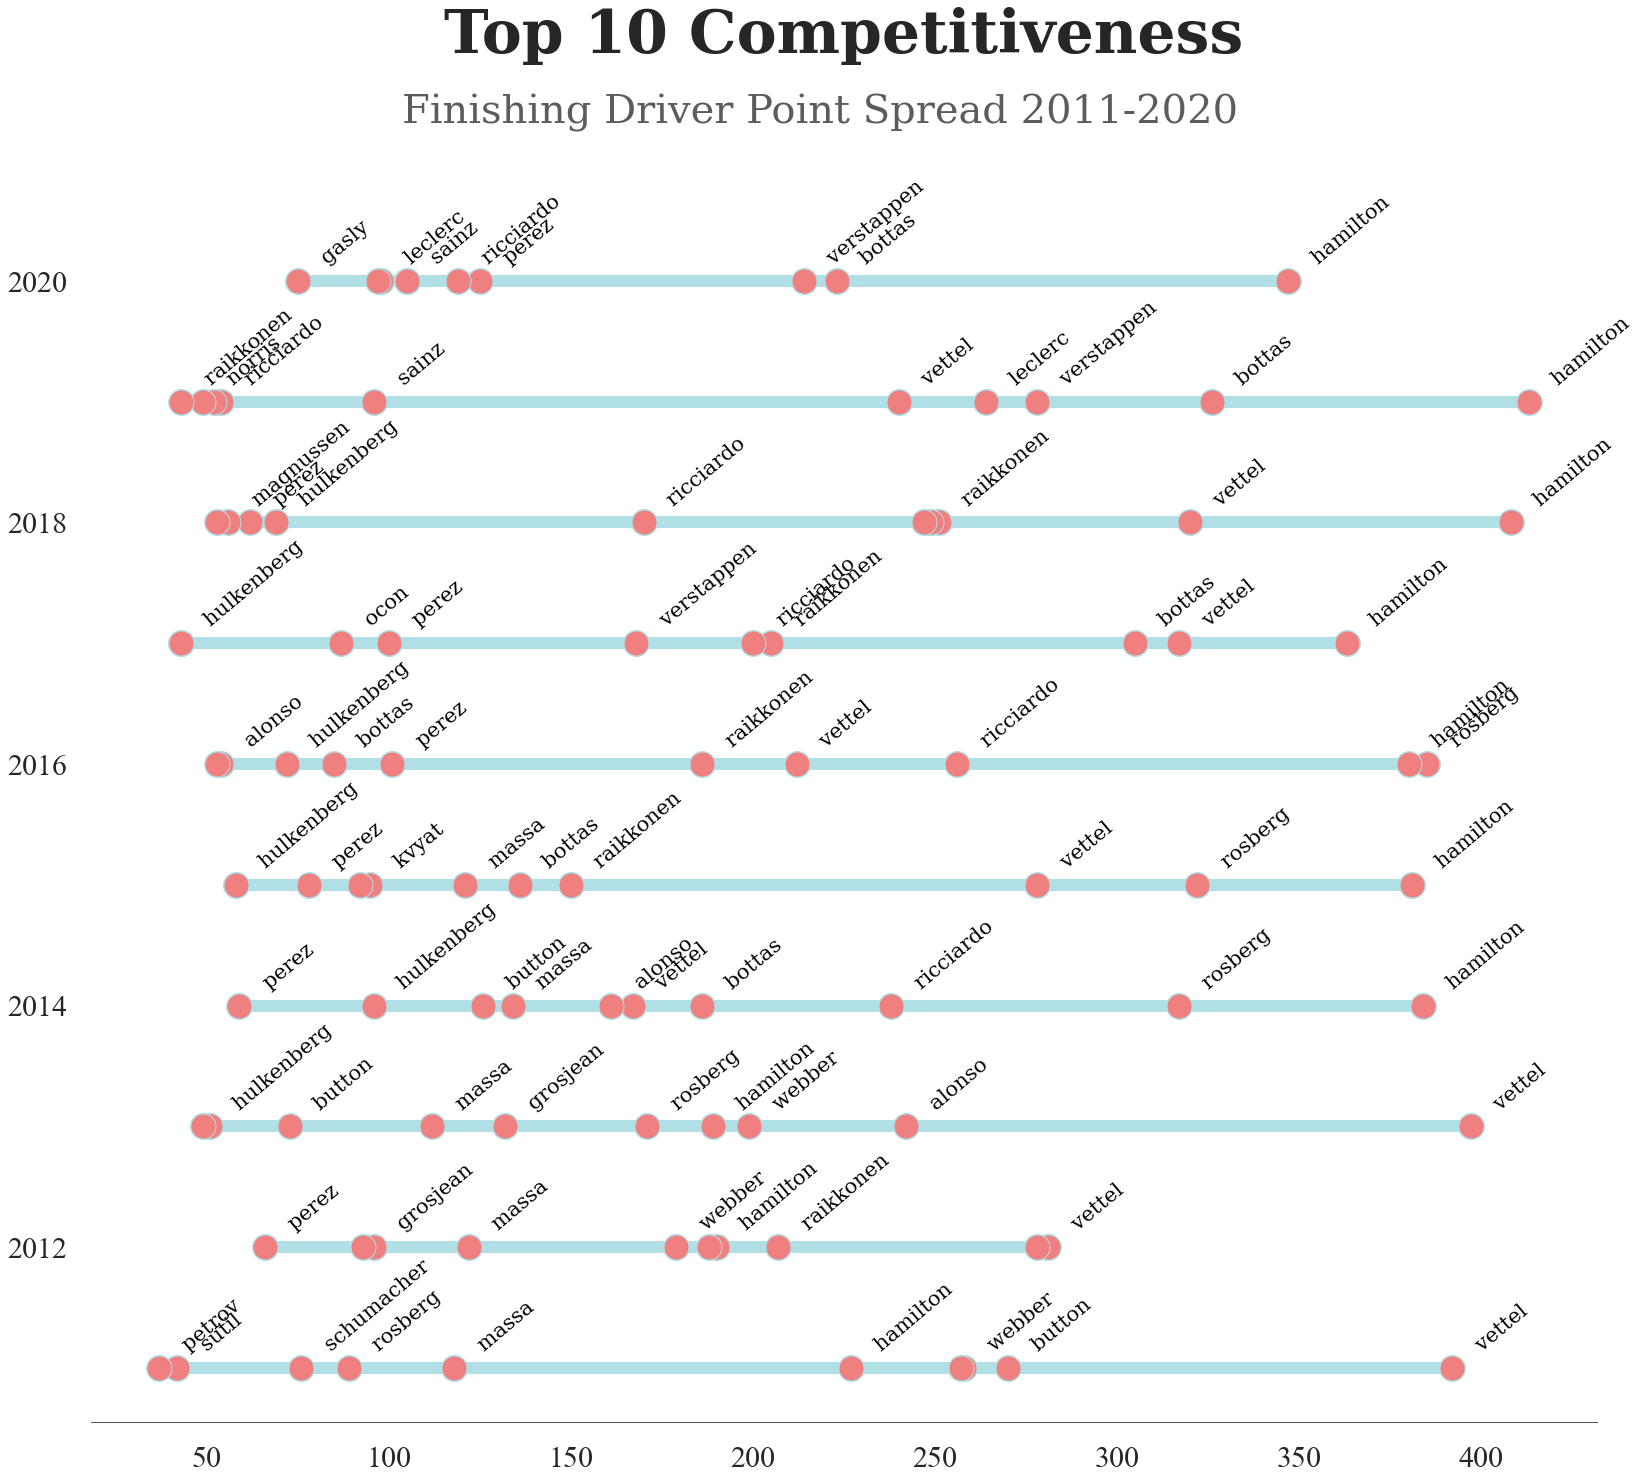

In [21]:
# Visualization settings
plt.figure(figsize=(27, 22))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='major', pad=20)
plt.yticks(fontname="Times New Roman", size=30)
plt.xticks(fontname="Times New Roman", size=30)

ax.set_title(label='Top 10 Competitiveness', 
                x=0.5, y=1.13,
                fontsize=60, 
                weight='bold', 
                ha='center', 
                va='bottom')
plt.suptitle(t='Finishing Driver Point Spread 2011-2020', 
            x=0.5, y=0.94,
            fontsize=40, 
            alpha=0.75,
            weight='light', 
            ha='center', 
            va='bottom')

comp = f1_data
comp['last_round'] = [comp.groupby('season').round.max()[year] for year in comp['season']]
comp = comp[comp['round'] == comp['last_round']][['season', 'round', 'full_name', 'points_after']]
comp = comp.groupby(['season']).apply(pd.DataFrame.sort_values, 'points_after', ascending=False)
comp.reset_index(drop=True, inplace=True) 

# Find Top 10 Championship Points Spread at the End of Each Season
final_comp = pd.DataFrame()
for season in comp['season'].unique():
    df = comp[comp['season'] == season].head(10)
    final_comp = pd.concat([final_comp, df], axis=0)

final_comp['full_name'] = final_comp['full_name'].apply(lambda x: x.split('_')[-1])
final_comp = final_comp[final_comp['season'] > 2010]

# Multiple line plots
for year in final_comp['season']:
    plt.plot('points_after', 
            'season', 
            data=final_comp[final_comp['season']==year], 
            marker='o',
            markeredgecolor='powderblue',
            markerfacecolor='lightcoral',
            markersize=25, 
            color='powderblue', 
            linewidth=12
            )
    
# label points on the plot
count = 0
year = 2010
for x, y, z in zip(final_comp['points_after'], final_comp['season'], final_comp['full_name']):

    if year == y:
        if x >= (count-4):
            pass
        else:
            plt.text(x = x, # x-coordinate position of data label
                     y = y, # y-coordinate position of data label, adjusted to be 150 below the data point
                     s = '    ' + z, # data label, formatted to ignore decimals
                     color = 'black', # set colour of line
                     rotation = 40,
                     size = 21) 
            count -= (count-x)
            
    else:
        year += 1
        count = 0
        if x <= (count-4):
            pass
        else:
            plt.text(x = x, # x-coordinate position of data label
                     y = y, # y-coordinate position of data label, adjusted to be 150 below the data point
                     s = '    ' + z, # data label, formatted to ignore decimals
                     color = 'black', # set colour of line
                     rotation = 40,
                     size = 21) 
            count -= (count-x)

sns.set_style({'font.family':'serif', 'font.serif':'Garamond'})
plt.savefig('driver_comp_vf.jpeg', dpi=500, bbox_inches = "tight")


### Feature Correlation Heatmap Visualization

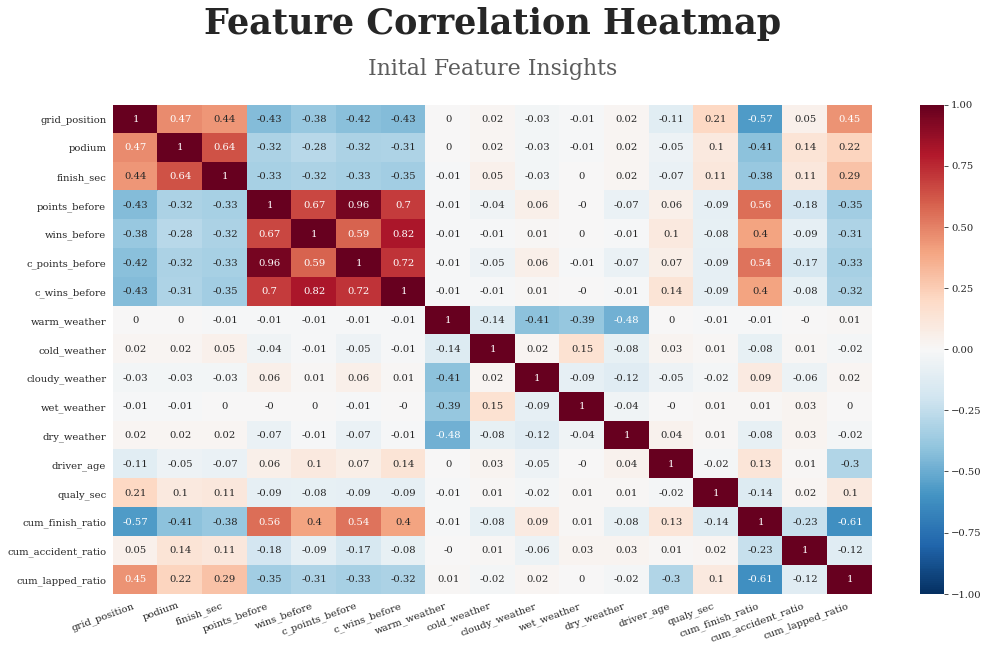

In [585]:
plt.figure(figsize=(17, 9))
plt.xticks(ha='right')
data = ['grid_position', 'podium', 'finish_sec', 
        'points_before', 'wins_before', 'c_points_before', 
        'c_wins_before', 'warm_weather', 'cold_weather', 
        'cloudy_weather', 'wet_weather', 'dry_weather', 
        'driver_age', 'qualy_sec', 'cum_finish_ratio',
        'cum_accident_ratio', 'cum_lapped_ratio'
       ]

heatmap = sns.heatmap(round(f1_data[data].corr(), 2), vmin=-1, vmax=1, annot=True, cmap="RdBu_r")
heatmap.tick_params(axis='x', labelrotation=20)
sns.set_style({'font.family':'serif', 'font.serif':'Garamond'})
heatmap.text(x=0.5, y=1.13, 
             s='Feature Correlation Heatmap', 
             fontsize=35, 
             weight='bold', 
             ha='center', 
             va='bottom', 
             transform=heatmap.transAxes)
heatmap.text(x=0.5, y=1.05, 
           s='Inital Feature Insights', 
           fontsize=22, 
           alpha=0.75, 
           ha='center', 
           va='bottom', 
           transform=heatmap.transAxes)

#heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':13}, pad=15)

plt.savefig('corr_heatmap_vf.jpeg', dpi=700, bbox_inches = "tight")


### DNF/Finished Status by Season Visualization

season,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
DNF_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
accident,44,53,47,37,37,38,69,49,45,59,64,80,61,65,61,50,42,55,33,26,21,38,30,51,42,34,34,47,35,52,28,33,33,34,34,35,30,23
finished,71,56,55,52,55,73,65,87,79,68,58,63,67,88,127,87,112,106,98,94,103,137,143,143,146,184,205,209,170,273,244,198,169,181,162,189,178,190
lapped,111,89,104,106,121,128,117,111,109,134,133,122,136,72,73,108,63,113,107,106,98,118,118,113,121,86,49,126,195,115,110,118,124,164,138,142,149,88
mechanical_issue,154,185,162,200,196,160,130,135,127,102,96,107,95,93,83,72,91,78,94,98,64,51,56,62,46,25,29,70,42,34,34,51,43,40,56,48,28,33


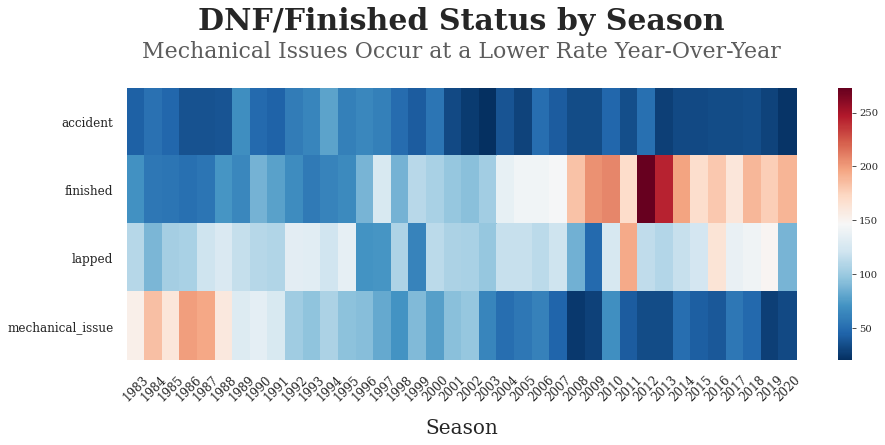

In [587]:
# Data Manipulation
dnf_data = f1_data.groupby(['season', 'DNF_status']).count().reset_index()
dnf_data = dnf_data.pivot(index='season', columns='DNF_status', values='round').T
display(dnf_data.head())

fig, axs = plt.subplots(figsize=(15,5)) 
heatmap = sns.heatmap(dnf_data, cmap="RdBu_r")
sns.set_style({'font.family':'serif', 'font.serif':'Garamond'})
axs.set_xlabel("Season", fontsize=20, labelpad=15)
axs.set_ylabel("DNF Status", fontsize=20, labelpad=15)
axs.tick_params(axis='y', labelsize=20, pad=10)
axs.tick_params(axis='x', labelsize=17, pad=10)

heatmap.text(x=0.5, y=1.19, 
           s='DNF/Finished Status by Season', 
           fontsize=30, 
           weight='bold', 
           ha='center', 
           va='bottom', 
           transform=heatmap.transAxes)
heatmap.text(x=0.5, y=1.09, 
           s='Mechanical Issues Occur at a Lower Rate Year-Over-Year', 
           fontsize=22, 
           alpha=0.75, 
           ha='center', 
           va='bottom', 
           transform=heatmap.transAxes)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, size=12) 
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, size=12) 
heatmap.set(ylabel=None)
#heatmap.set_title('DNF/Finished Status by Season', fontdict={'fontsize':20}, pad=20)

plt.savefig('finishing_status_vf.jpeg', dpi=700, bbox_inches = "tight")



### Teammates & Rivals: How do Hamilton and Bottas Compare (Part 1) Visualization

TypeError: labels() missing 5 required positional arguments: 'fontsize', 'title', 'subtitle', 'title_pos', and 'subtitle_pos'

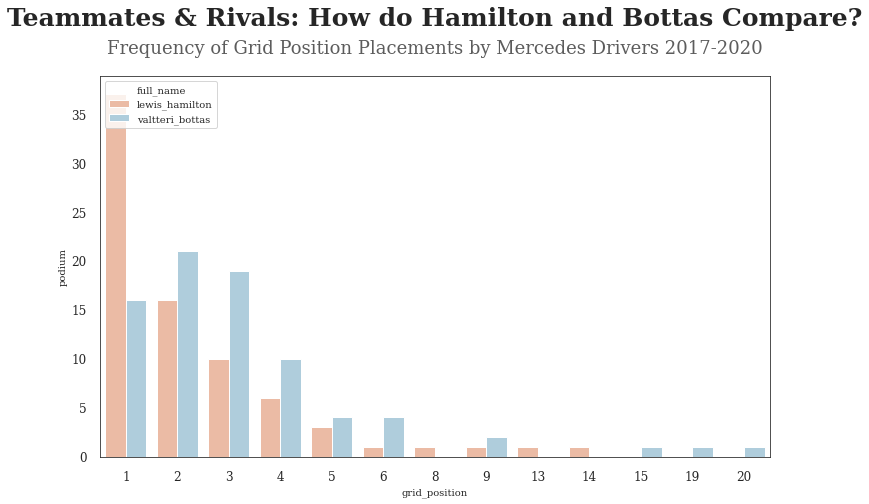

In [588]:
ham_bot = f1_data[(f1_data['full_name'] == 'lewis_hamilton') | (f1_data['full_name'] == 'valtteri_bottas')]
ham_bot = ham_bot[(f1_data['season'] > 2016)][['season', 'full_name', 'round', 'grid_position', 'podium']]
ham_bot_df = ham_bot.groupby(['full_name', 'grid_position']).count().reset_index()
ham_bot_df2 = ham_bot.groupby(['full_name', 'podium']).count().reset_index()
ham_bot_df = ham_bot_df.drop(['season', 'round'], axis=1)
ham_bot_df2 = ham_bot_df2.drop(['season', 'round'], axis=1)

fig, axs = plt.subplots(figsize=(12,7)) 
axs.tick_params(axis='y', labelsize=12, pad=10)
axs.tick_params(axis='x', labelsize=12, pad=10)

grid = sns.barplot(x='grid_position', 
                   y='podium', 
                   hue="full_name", 
                   data=ham_bot_df,
                   palette=sns.color_palette("RdBu", 2))

grid.text(x=0.5, y=1.12, 
        s='Teammates & Rivals: How do Hamilton and Bottas Compare?', 
        fontsize=25, 
        weight='bold', 
        ha='center', 
        va='bottom', 
        transform=grid.transAxes)
grid.text(x=0.5, y=1.05, 
        s='Frequency of Grid Position Placements by Mercedes Drivers 2017-2020', 
        fontsize=18, 
        alpha=0.75, 
        ha='center', 
        va='bottom', 
        transform=grid.transAxes)

labels(xlabel='Grid Position', 
       ylabel='Frequency of Gird Position Placements', 
       pad=20,
       data=grid)

sns.axes_style('white')
sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})
sns.despine(ax=grid, bottom=False, left=True)
plt.legend(bbox_to_anchor=(0.9, 1), loc=2, fontsize=12, frameon=False)
plt.savefig('mercedes_grid_vf.jpeg', dpi=1000, bbox_inches = "tight")



### Teammates & Rivals: How do Hamilton and Bottas Compare (Part 2) Visualization

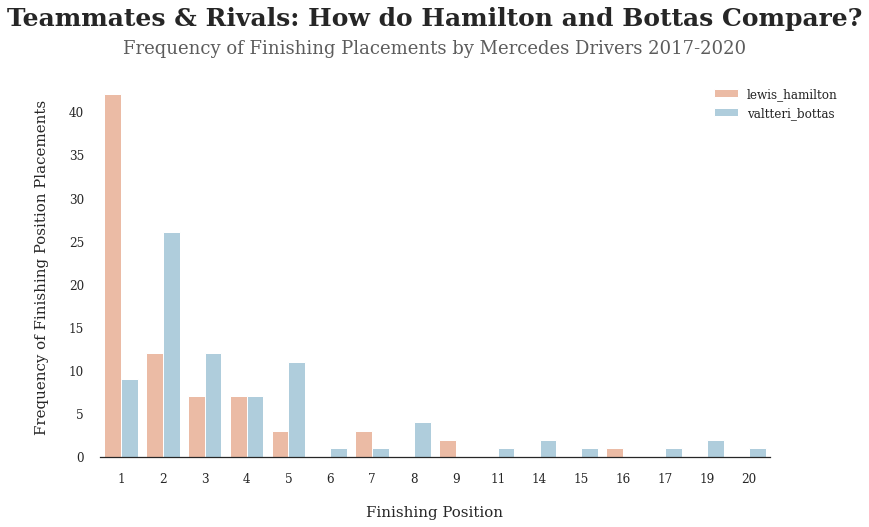

In [1063]:
fig, axs = plt.subplots(figsize=(12,7)) 
axs.tick_params(axis='y', labelsize=12, pad=10)
axs.tick_params(axis='x', labelsize=12, pad=10)

podium = sns.barplot(x='podium', 
                   y='grid_position', 
                   hue="full_name", 
                   data=ham_bot_df2,
                   palette=sns.color_palette("RdBu", 2))

podium.text(x=0.5, y=1.12, 
        s='Teammates & Rivals: How do Hamilton and Bottas Compare?', 
        fontsize=25, 
        weight='bold', 
        ha='center', 
        va='bottom', 
        transform=podium.transAxes)
podium.text(x=0.5, y=1.05, 
        s='Frequency of Finishing Placements by Mercedes Drivers 2017-2020', 
        fontsize=18, 
        alpha=0.75, 
        ha='center', 
        va='bottom', 
        transform=podium.transAxes)

labels(xlabel='Finishing Position', 
       ylabel='Frequency of Finishing Position Placements', 
       pad=20,
       data=podium)

sns.axes_style('white')
sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})
sns.despine(ax=podium, bottom=False, left=True)
plt.legend(bbox_to_anchor=(0.9, 1), loc=2, fontsize=12, frameon=False)
plt.savefig('mercedes_grid_vf2.jpeg', dpi=1000, bbox_inches = "tight")



### Which Driver is Faster in the Rain in 2020 Visualization

weather_data,full_name,rain_control
15,senna,25.909051
90,stroll,7.941825
155,vettel,7.070179
159,perez,1.545617
92,hamilton,1.429994
19,sainz,1.010569
174,bottas,-7.214375
29,ricciardo,-8.996688
52,russell,-12.282857
20,leclerc,-12.634765


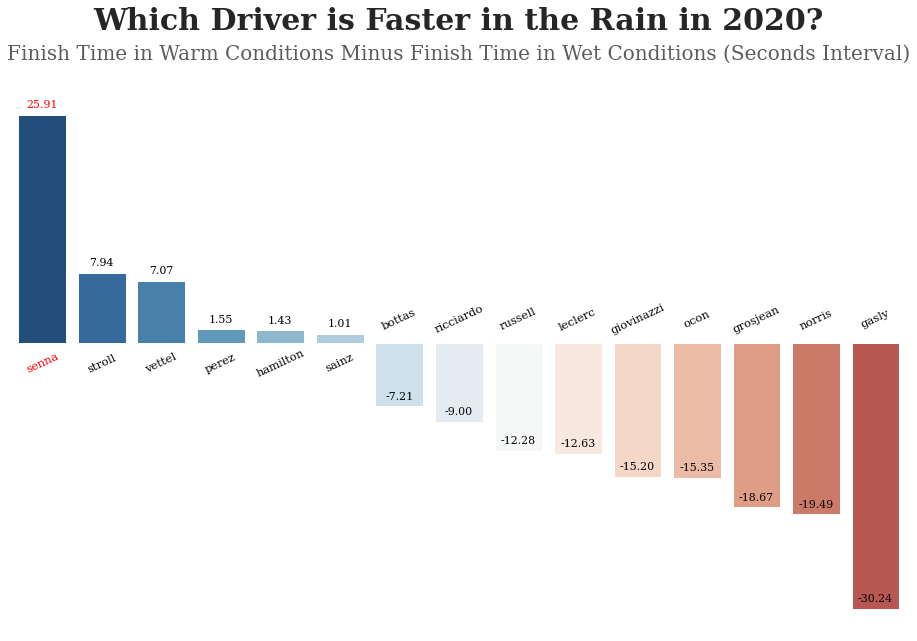

In [630]:
weather = f1_data[['warm_weather', 'cold_weather','dry_weather', 'wet_weather', 'cloudy_weather']]
f1_data['weather_data'] = pd.Series(weather.columns[np.where(weather!=0)[1]])
weather_data = f1_data.groupby(['season', 'full_name', 'weather_data']).mean().reset_index()
weather_data = weather_data[['season','full_name', 'weather_data', 'qualy_sec', 'finish_sec', 'podium']]

weather_data = weather_data[(weather_data['weather_data'] == 'warm_weather') | (weather_data['weather_data'] == 'wet_weather')].reset_index(drop=True)
#display(weather_data.tail(6))
warm_wet = weather_data.pivot(index=['full_name', 'season'], columns='weather_data', values='finish_sec').reset_index()
warm_wet = warm_wet.dropna(how='any',axis=0) 
warm_wet['rain_control'] = warm_wet['warm_weather'] - warm_wet['wet_weather']
warm_wet = warm_wet.groupby(['full_name']).mean().reset_index()[['full_name', 'rain_control']]

warm_wet = warm_wet.sort_values('rain_control', ascending=False)

warm_wet = warm_wet[(warm_wet['full_name'] == 'valtteri_bottas') |
                    (warm_wet['full_name'] == 'lewis_hamilton') |
                    (warm_wet['full_name'] == 'lando_norris') |
                    (warm_wet['full_name'] == 'charles_leclerc') |
                    (warm_wet['full_name'] == 'george_russell') |
                    (warm_wet['full_name'] == 'daniel_ricciardo') |
                    (warm_wet['full_name'] == 'pierre_gasly') |
                    (warm_wet['full_name'] == 'sergio_perez') |
                    (warm_wet['full_name'] == 'carlos_sainz') |
                    (warm_wet['full_name'] == 'romain_grosjean') |
                    (warm_wet['full_name'] == 'lance_stroll') |
                    (warm_wet['full_name'] == 'sebastian_vettel') |
                    (warm_wet['full_name'] == 'esteban_ocon') |
                    (warm_wet['full_name'] == 'antonio_giovinazzi') |
                    (warm_wet['full_name'] == 'ayrton_senna')
                   ]

warm_wet['full_name'] = warm_wet['full_name'].apply(lambda x: x.split("_")[-1])
display(warm_wet.head(30))

# Visualization

fig, axs = plt.subplots(figsize=(16,10)) 

x = warm_wet['full_name']
y = warm_wet['rain_control']
colors = reversed(sns.color_palette("RdBu", 17))
ax = sns.barplot(x, y, palette=colors)
axs.set_ylabel(ylabel="")
axs.set_xlabel(xlabel="")
ax.text(x=0.5, y=1.1, 
        s='Which Driver is Faster in the Rain in 2020?', 
        fontsize=30, 
        weight='bold', 
        ha='center', 
        va='bottom', 
        transform=ax.transAxes)
ax.text(x=0.5, y=1.05, 
        s='Finish Time in Warm Conditions Minus Finish Time in Wet Conditions (Seconds Interval)', 
        fontsize=20, 
        alpha=0.75, 
        ha='center', 
        va='bottom', 
        transform=ax.transAxes)
sns.axes_style('white')
sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})

for n, (label, _y) in enumerate(zip(x, y)):
    
    if label == 'senna':
        color='red'
    else:
        color='black'
        
    ax.annotate(
        text='{:.2f}'.format(_y),
        xy=(n, _y),
        ha='center',va='center',
        xytext=(0,10),
        textcoords='offset points',
        color=color,
        weight='light',
        size=11
    )
    
    if _y > 0:
        ax.annotate(
            text=label,
            xy=(n, -4),
            rotation=25,
            ha='center',va='center',
            xytext=(0,15),
            color=color,
            textcoords='offset points',
            size=11.5
        )  
    else:
        ax.annotate(
            text=label,
            xy=(n, 1),
            rotation=25,
            ha='center',va='center',
            xytext=(0,15),
            color=color,
            textcoords='offset points',
            size=11.5
        )
    
# axes formatting
ax.set_yticks([])
ax.set_xticks([])
sns.despine(ax=ax, bottom=True, left=True)

plt.savefig('weather_finish_vf2.jpeg', dpi=700)



### Dry/Wet Track Conditions Correlation Heatmap Visualization

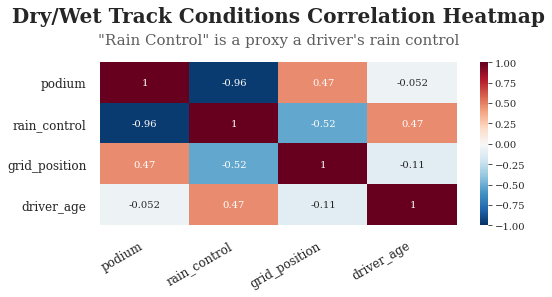

In [631]:
# Is this ultimately correlated with podium finishes (should be negatively correlated...)

warm_wet = warm_wet[['full_name', 'rain_control']].reset_index(drop=True).rename_axis(None, axis=1)
weather_corr = pd.concat([f1_data, warm_wet], axis=1)

figure_params(x_fig=8, 
              y_fig=3, 
              x_rot=35,
              tick_fontsize=15)

corr_heatmap = sns.heatmap(weather_corr[['podium', 'rain_control', 'grid_position', 'driver_age']].corr(), 
                           vmin=-1, 
                           vmax=1, 
                           annot=True,
                           cmap="RdBu_r")

corr_heatmap.text(x=0.5, y=1.22, 
           s='Dry/Wet Track Conditions Correlation Heatmap', 
           fontsize=20, 
           weight='bold', 
           ha='center', 
           va='bottom', 
           transform=corr_heatmap.transAxes)
corr_heatmap.text(x=0.5, y=1.09, 
           s='"Rain Control" is a proxy a driver\'s rain control', 
           fontsize=15, 
           alpha=0.75, 
           ha='center', 
           va='bottom', 
           transform=corr_heatmap.transAxes)

corr_heatmap.set_yticklabels(corr_heatmap.get_yticklabels(), rotation=0, size=12) 
corr_heatmap.set_xticklabels(corr_heatmap.get_xticklabels(), rotation=30, size=12) 

#corr_heatmap.set_title('Warm/Wet Track Conditions Correlation Heatmap', fontdict={'fontsize':13}, pad=15)

plt.savefig('warm_wet_corr_vf.jpeg', dpi=1000, bbox_inches = "tight")



### Accident Ratio in Warm vs. Wet Track Conditions by Season Visualization

,season,weather_data,accident_ratio
144,2018,warm_weather,0.065421
145,2018,wet_weather,0.100000
147,2019,warm_weather,0.090517
148,2019,wet_weather,0.095238
151,2020,warm_weather,0.022989
152,2020,wet_weather,0.078947


AttributeError: 'DataFrame' object has no attribute 'get_figure'

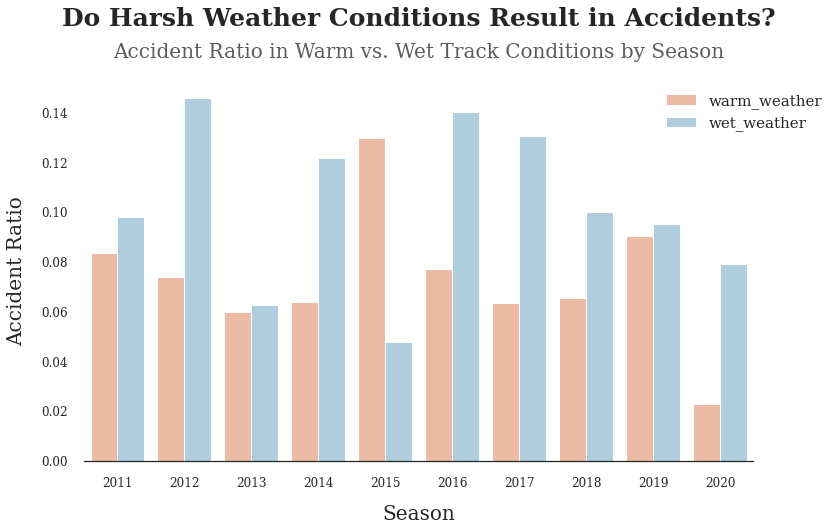

In [1123]:
# Accidents in wet weather

weather = f1_data[['warm_weather', 'cold_weather','dry_weather', 'wet_weather', 'cloudy_weather']]
f1_data['weather_data'] = pd.Series(weather.columns[np.where(weather!=0)[1]])
weather_data = f1_data.groupby(['season', 'weather_data']).sum().reset_index()
weather_data['accidents_per_season'] = weather_data['accident']
weather_data['racers_per_season'] = f1_data.groupby(['season', 'weather_data']).count().reset_index()['accident']
weather_data['accident_ratio'] = weather_data['accidents_per_season'] / weather_data['racers_per_season']

weather_data = weather_data[['season', 'weather_data', 'accident_ratio']]
weather_data = weather_data[(weather_data['weather_data'] == 'warm_weather') | (weather_data['weather_data'] == 'wet_weather')]
display(weather_data.tail(6))

# Complete Visualization for Bar Charts

fig, axs = plt.subplots(figsize=(12,7)) 
axs.tick_params(axis='y', labelsize=12, pad=10)
axs.tick_params(axis='x', labelsize=12, pad=10)
sns.set_style({'font.family':'serif', 'font.serif':'Garamond'})

item = sns.barplot(x='season', 
                   y='accident_ratio', 
                   hue="weather_data",  
                   data=weather_data[weather_data['season'] > 2010],
                   palette=sns.color_palette("RdBu", 2))

item.text(x=0.5, y=1.13, 
           s='Do Harsh Weather Conditions Result in Accidents?', 
           fontsize=25, 
           weight='bold', 
           ha='center', 
           va='bottom', 
           transform=item.transAxes)
item.text(x=0.5, y=1.05, 
           s='Accident Ratio in Warm vs. Wet Track Conditions by Season', 
           fontsize=20, 
           alpha=0.75, 
           ha='center', 
           va='bottom', 
           transform=item.transAxes)

sns.despine(ax=item, bottom=False, left=True)
labels('Season', 'Accident Ratio', 15, 20, item)
plt.legend(bbox_to_anchor=(0.85, 1), loc=2, fontsize=15, frameon=False)

plt.savefig('accident_ratio_vf.jpeg', dpi=800, bbox_inches = "tight")
ax = weather_data.tail(6)
fig = ax.get_figure()
fig.savefig('test.png')



### Number of Accidents compared to Number of Drivers Raced (Accident Ratio) Visualization

,circuit_id,accident,total_racers,track_ratio,normalized
1,adelaide,55,255,0.215686,1.000000
24,long_beach,6,28,0.214286,0.992892
27,monaco,131,823,0.159174,0.713211
45,villeneuve,122,787,0.155019,0.692127
43,suzuka,86,657,0.130898,0.569718


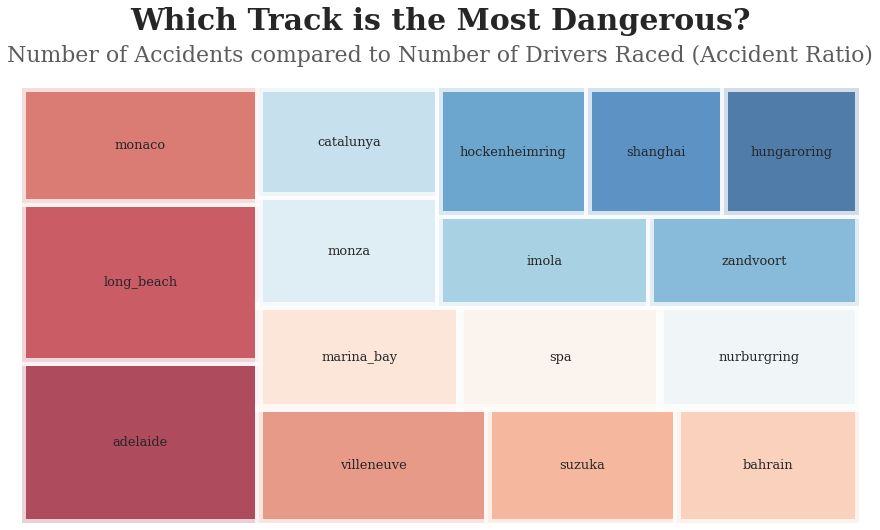

In [1074]:
# Accidents per track
track_data = f1_data[['accident', 'mechanical_issue', 'finished', 'lapped']]
f1_data['track_data'] = pd.Series(track_data.columns[np.where(track_data!=0)[1]])
track_data = f1_data.groupby(['circuit_id', 'track_data']).count().reset_index()
new_track_data = track_data[track_data['track_data'] == 'accident'].reset_index()
new_track_data['total_racers'] = track_data.groupby(['circuit_id']).sum().reset_index()['round']
new_track_data = new_track_data[['circuit_id', 'accident', 'total_racers']]
new_track_data['track_ratio'] = new_track_data['accident'] / new_track_data['total_racers']
new_track_data = new_track_data[(new_track_data['circuit_id'] != 'dallas') &
                                (new_track_data['circuit_id'] != 'estoril') &
                                (new_track_data['circuit_id'] != 'galvez') &
                                (new_track_data['circuit_id'] != 'okayama') &
                                (new_track_data['circuit_id'] != 'donington') &
                                (new_track_data['circuit_id'] != 'magny_cours') &
                                (new_track_data['circuit_id'] != 'fuji') &
                                (new_track_data['circuit_id'] != 'brands_hatch') &
                                (new_track_data['circuit_id'] != 'detroit') &
                                (new_track_data['circuit_id'] != 'jerez')
                               ]
new_track_data = new_track_data.sort_values('track_ratio', ascending=False)

new_track_data['normalized'] = (new_track_data['track_ratio'] - new_track_data['track_ratio'].min()) / (new_track_data['track_ratio'].max() - new_track_data['track_ratio'].min())
new_track_data = new_track_data.iloc[:16, :]
display(new_track_data.head())

fig, axs = plt.subplots(figsize=(15,8)) 
axs.set_ylabel(ylabel="")
axs.set_xlabel(xlabel="")
sns.axes_style('white')
sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})

visual = squarify.plot(sizes=new_track_data['normalized'],
                       color=sns.color_palette("RdBu", 16),
                       label=new_track_data['circuit_id'],
                       alpha=0.75, 
                       edgecolor="white", 
                       linewidth=8,
                       text_kwargs={'fontsize':13})

visual.text(x=0.5, y=1.12, 
            s='Which Track is the Most Dangerous?', 
            fontsize=30, 
            weight='bold', 
            ha='center', 
            va='bottom', 
            transform=visual.transAxes)
visual.text(x=0.5, y=1.05, 
            s='Number of Accidents compared to Number of Drivers Raced (Accident Ratio)', 
            fontsize=22, 
            alpha=0.75, 
            ha='center', 
            va='bottom', 
            transform=visual.transAxes)

plt.axis('off')

plt.savefig('dangerous_track_vf.jpeg', dpi=1000, bbox_inches = "tight")



### Legacy Constructor Points from 1960 to 2020 Visualization

,constructor,season,points_after
21,ferrari,1981,25.0
22,ferrari,1982,39.0
23,ferrari,1983,49.0
24,ferrari,1984,30.5
25,ferrari,1985,53.0


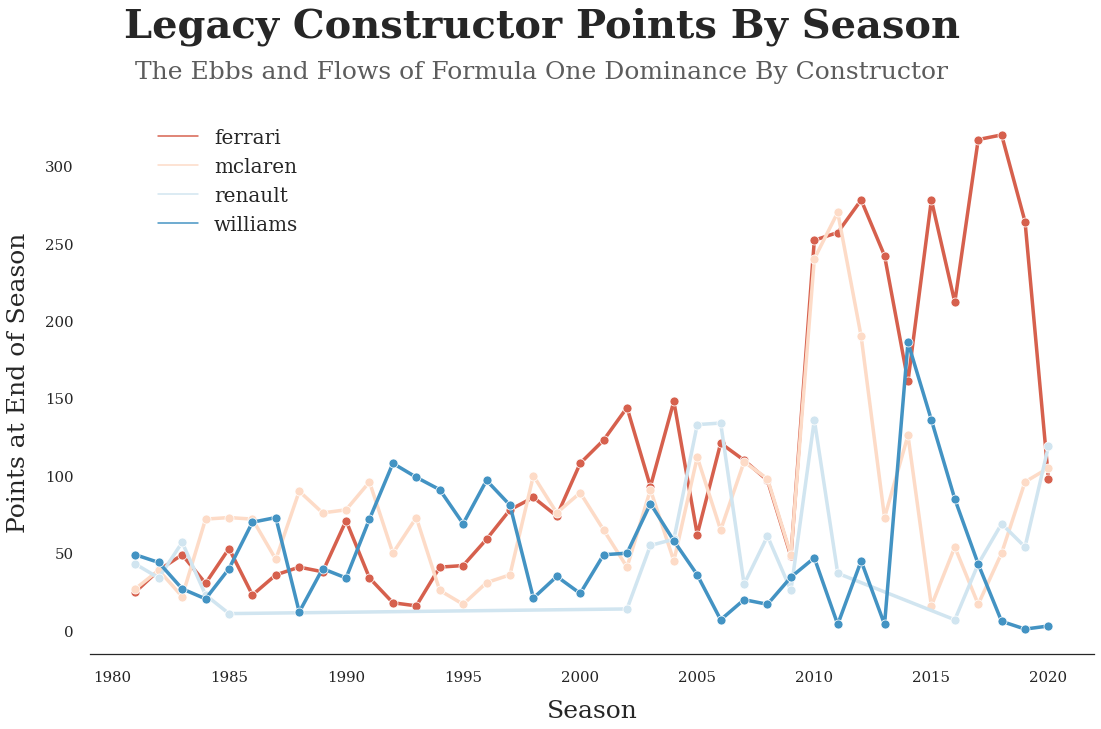

In [1122]:
const_data = f1_races[(f1_races['constructor'] == 'ferrari') |
                      (f1_races['constructor'] == 'mclaren') |
                      (f1_races['constructor'] == 'renault') |
                      (f1_races['constructor'] == 'williams')
                     ]
const_data = const_data.groupby(['constructor', 'season']).max().reset_index()
const_data = const_data[['constructor', 'season', 'points_after']][const_data['season'] > 1980]
display(const_data.head())

fig, axs = plt.subplots(figsize=(18,10)) 
#axs.set_ylabel(ylabel="Points at End of Season", labelpad=20, fontsize=25)
#axs.set_xlabel(xlabel="Season", labelpad=20, fontsize=25)
axs.tick_params(axis='y', labelsize=15, pad=10)
axs.tick_params(axis='x', labelsize=15, pad=10)

const = sns.lineplot(x='season', 
                     y='points_after', 
                     hue='constructor', 
                     data=const_data,
                     palette=sns.color_palette("RdBu", 4),
                     marker='o',
                     markersize=9,
                     linewidth=3.5)

sns.axes_style('white')
sns.set_style('white', {'font.family':'serif', 'font.serif':'Garamond'})
sns.despine(ax=const, bottom=False, left=True)
plt.legend(bbox_to_anchor=(0.05, 1), loc=2, fontsize=20, frameon=False)
const.text(x=0.45, y=1.12, 
           s='Legacy Constructor Points By Season', 
           fontsize=40, 
           weight='bold', 
           ha='center', 
           va='bottom', 
           transform=const.transAxes)
const.text(x=0.45, y=1.05, 
           s='The Ebbs and Flows of Formula One Dominance By Constructor', 
           fontsize=25, 
           alpha=0.75, 
           ha='center', 
           va='bottom', 
           transform=const.transAxes)

labels('Season', 'Points at End of Season', 15, 25, const)
plt.savefig('legacy_constructor_vf.jpeg', dpi=700, bbox_inches = "tight")



### Lewis Hamilton in Qualifying Compared to Teammates (Part 1) Visualization

,season,full_name,index,qualy_sec_diff,finish_sec_diff
0,2010,button,9751.230769,0.445923,7.042692
1,2012,button,10632.222222,0.442889,16.488222
2,2009,kovalainen,9402.142857,0.244857,24.857857
3,2017,bottas,12693.470588,0.199941,9.150059
4,2020,bottas,13844.571429,0.176286,10.098857
5,2011,button,10195.142857,0.142500,-12.502571
6,2015,rosberg,11890.250000,0.128750,0.339187
7,2019,bottas,13499.055556,0.122222,5.391444
8,2018,bottas,13105.833333,0.106111,21.817222
9,2008,kovalainen,9055.500000,0.067600,6.070500


[]

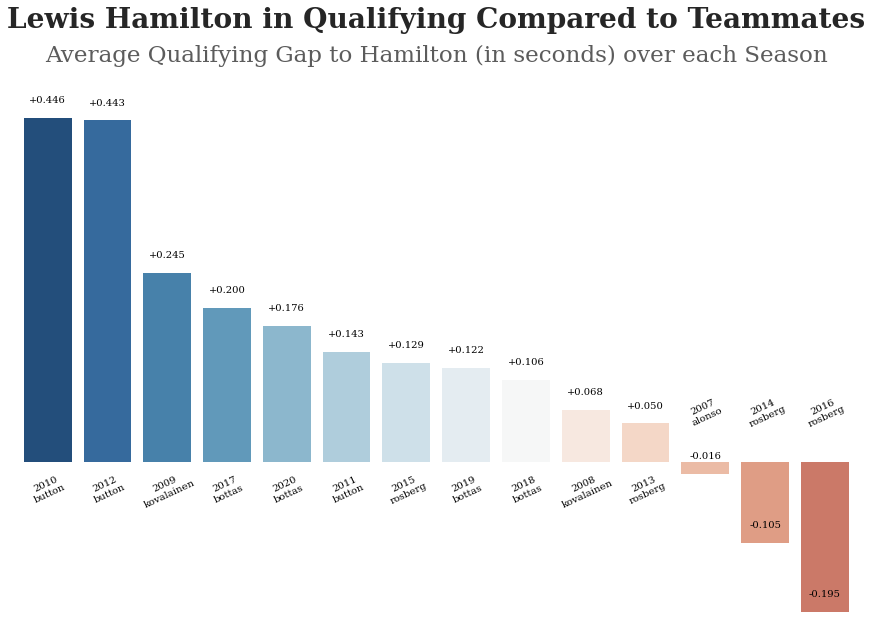

In [7]:
def ham_teammates(mate, season_start, season_end):
    ham_comp = f1_data[['season', 'round','full_name', 'qualy_sec', 'finish_sec', 'constructor', 'DNF_status']]
    ham_comp = ham_comp[ham_comp['DNF_status'] == 'finished']
    ham_comp = ham_comp[(ham_comp['full_name'] == 'lewis_hamilton') |
                        (ham_comp['full_name'] == mate)]
    ham_comp = ham_comp[(ham_comp['season'] > season_start) & (ham_comp['season'] < season_end)].reset_index()
    
    # Delete races one of two drivers do not finish the race
    delete = ham_comp.groupby(['season', 'round']).count().reset_index()[['season', 'round', 'full_name']]
    delete = delete[delete['full_name'] < 2]
    for index, row in delete.iterrows():
        ham_comp.drop(ham_comp[(ham_comp['season'] == row['season']) & (ham_comp['round'] == row['round'])].index, 
                      inplace=True)
        
    ham_comp = ham_comp.groupby(['season', 'full_name']).mean().reset_index()
    ham_comp['full_name'] = ham_comp['full_name'].apply(lambda x: 'a_lewis_hamilton' if (x == 'lewis_hamilton') else x)
    ham_comp = ham_comp.sort_values(['season', 'full_name'], ascending=(True, True))
    ham_comp['qualy_sec_diff'] = ham_comp[['season', 'round', 'qualy_sec', 'finish_sec']].groupby(['season']).diff().reset_index()['qualy_sec']
    ham_comp['finish_sec_diff'] = ham_comp[['season', 'round', 'qualy_sec', 'finish_sec']].groupby(['season']).diff().reset_index()['finish_sec']
    ham_comp = ham_comp.dropna(axis=0, subset=['qualy_sec_diff'])
    ham_comp['full_name'] = mate
    ham_comp = ham_comp[(ham_comp['season'] > season_start) & (ham_comp['season'] < season_end)].head(20)
    return ham_comp

ham_teammate_df = pd.DataFrame()

ham_teammate_df = pd.concat([ham_teammates('fernando_alonso', 2006, 2008), ham_teammate_df])
ham_teammate_df = pd.concat([ham_teammates('heikki_kovalainen', 2007, 2010), ham_teammate_df])
ham_teammate_df = pd.concat([ham_teammates('jenson_button', 2009, 2013), ham_teammate_df])
ham_teammate_df = pd.concat([ham_teammates('nico_rosberg', 2012, 2017), ham_teammate_df])
ham_teammate_df = pd.concat([ham_teammates('valtteri_bottas', 2016, 2021), ham_teammate_df])

ham_teammate_df = ham_teammate_df.drop(['round', 'qualy_sec', 'finish_sec'], axis=1)
ham_teammate_df = ham_teammate_df.sort_values('qualy_sec_diff', ascending=False)
ham_teammate_df = ham_teammate_df.reset_index(drop=True)
ham_teammate_df['full_name'] = ham_teammate_df['full_name'].apply(lambda x: x.split("_")[-1])

display(ham_teammate_df.tail(40))

# Visualization

fig, axs = plt.subplots(figsize=(15,10)) 

x_2 = ham_teammate_df['season']
x = ham_teammate_df.sort_values('season', ascending=True).reset_index(drop=True)['season']
y = ham_teammate_df['qualy_sec_diff']
name = ham_teammate_df['full_name']
colors = reversed(sns.color_palette("RdBu", 17))
ax = sns.barplot(x=x, 
                 y='qualy_sec_diff', 
                 palette=colors, 
                 data=ham_teammate_df)

# Execute labelling function
labels(xlabel='', 
       ylabel='', 
       pad=0, 
       fontsize=18, 
       data=ax, 
       title='Lewis Hamilton in Qualifying Compared to Teammates', 
       subtitle='Average Qualifying Gap to Hamilton (in seconds) over each Season', 
       title_pos=1.11, 
       subtitle_pos=1.05)

for n, (label, _y, name) in enumerate(zip(x_2, y, name)):
    
    if _y > 0:
        ax.annotate(
            text="+" + '{:.3f}'.format(_y),
            xy=(n, _y),
            ha='center',va='center',
            xytext=(0,18),
            textcoords='offset points',
            color='black',
            weight='light')
        ax.annotate(
            text=str(label) + '\n' + name,
            xy=(n, -0.05),
            rotation=25,
            ha='center',va='center',
            xytext=(0,12),
            color='black',
            textcoords='offset points')  
    else:
        ax.annotate(
            text='{:.3f}'.format(_y),
            xy=(n, _y),
            ha='center',va='center',
            xytext=(0,18),
            textcoords='offset points',
            color='black',
            weight='light')
        ax.annotate(
            text=str(label) + '\n' + name,
            xy=(n, 0.05),
            rotation=25,
            ha='center',va='center',
            xytext=(0,12),
            color='black',
            textcoords='offset points',
        )
    
# axes formatting
ax.set_yticks([])
ax.set_xticks([])

#plt.savefig('hamilton_qualy_gap.jpeg', dpi=700, bbox_inches = "tight")


### Lewis Hamilton in Qualifying Compared to Teammates (Part 2) Visualization

,season,full_name,index,qualy_sec_diff,finish_sec_diff
0,2009,kovalainen,9402.142857,0.244857,24.857857
1,2018,bottas,13105.833333,0.106111,21.817222
2,2012,button,10632.222222,0.442889,16.488222
3,2020,bottas,13844.571429,0.176286,10.098857
4,2017,bottas,12693.470588,0.199941,9.150059
5,2010,button,9751.230769,0.445923,7.042692
6,2008,kovalainen,9055.500000,0.067600,6.070500
7,2019,bottas,13499.055556,0.122222,5.391444
8,2016,rosberg,12309.888889,-0.194778,3.083944
9,2014,rosberg,11516.416667,-0.105083,2.691083


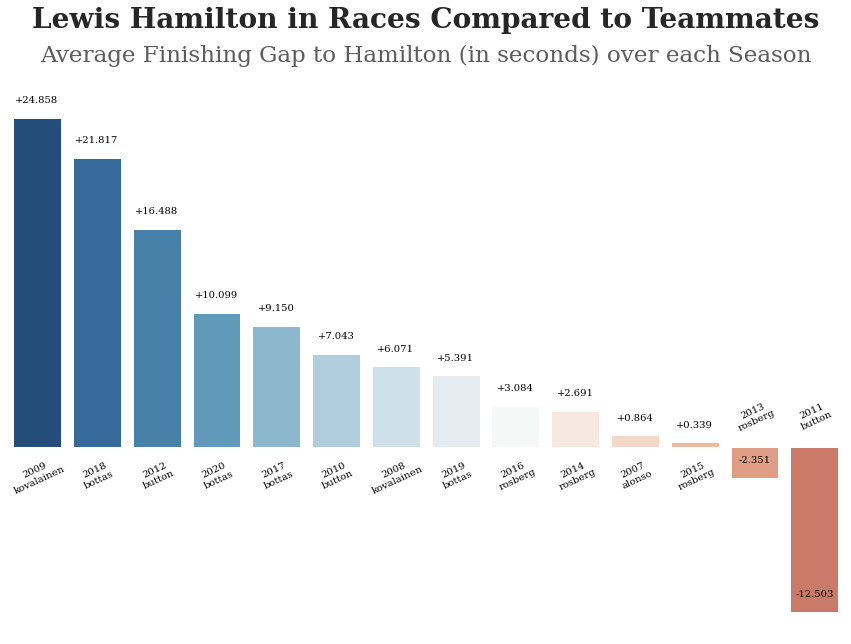

In [22]:
ham_teammate_df = ham_teammate_df.sort_values('finish_sec_diff', ascending=False)
ham_teammate_df = ham_teammate_df.reset_index(drop=True)
ham_teammate_df['full_name'] = ham_teammate_df['full_name'].apply(lambda x: x.split("_")[-1])

display(ham_teammate_df.tail(40))

# Visualization

fig, axs = plt.subplots(figsize=(15,10)) 

x_2 = ham_teammate_df['season']
x = ham_teammate_df.sort_values('season', ascending=True).reset_index(drop=True)['season']
y = ham_teammate_df['finish_sec_diff']
name = ham_teammate_df['full_name']
colors = reversed(sns.color_palette("RdBu", 17))
ax = sns.barplot(x=x, 
                 y='finish_sec_diff', 
                 palette=colors, 
                 data=ham_teammate_df)

# Execute labelling function
labels(xlabel='', 
       ylabel='', 
       pad=0, 
       fontsize=18, 
       data=ax, 
       title='Lewis Hamilton in Races Compared to Teammates', 
       subtitle='Average Finishing Gap to Hamilton (in seconds) over each Season', 
       title_pos=1.11, 
       subtitle_pos=1.05)

for n, (label, _y, name) in enumerate(zip(x_2, y, name)):
    
    if _y > 0:
        ax.annotate(
            text="+" + '{:.3f}'.format(_y),
            xy=(n, _y),
            ha='center',va='center',
            xytext=(0,18),
            textcoords='offset points',
            color='black',
            weight='light')
        ax.annotate(
            text=str(label) + '\n' + name,
            xy=(n, -3),
            rotation=25,
            ha='center',va='center',
            xytext=(0,12),
            color='black',
            textcoords='offset points')  
    else:
        ax.annotate(
            text='{:.3f}'.format(_y),
            xy=(n, _y),
            ha='center',va='center',
            xytext=(0,18),
            textcoords='offset points',
            color='black',
            weight='light')
        ax.annotate(
            text=str(label) + '\n' + name,
            xy=(n, 1.5),
            rotation=25,
            ha='center',va='center',
            xytext=(0,12),
            color='black',
            textcoords='offset points',
        )
    
# axes formatting
ax.set_yticks([])
ax.set_xticks([])

plt.savefig('hamilton_finish_gap.jpeg', dpi=700, bbox_inches = "tight")

